In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import SALib
from SALib.plotting import bar
import seaborn as sns
# read Sobol' sensitivity indices as dataframe
from settings import SOBOL_DATA_DIR, FIGURE_DIR
from utils.Sobol_G_setting import set_sobol_g_func

## Plot Sobol' SA with dummy parameter included

<Figure size 576x432 with 0 Axes>

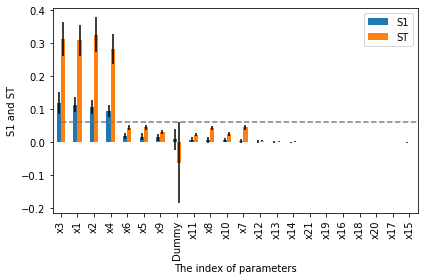

In [4]:
df = pd.read_csv(f'../output/sobol/Sobol_indices.csv', index_col = 'Unnamed: 0')
a, x, x_bounds, x_names, len_params, problem = set_sobol_g_func()

df_plot = pd.DataFrame()
df_plot.loc[:, 'S1'] = df[df.Type == 'S1']['result_5000'].values
df_plot.loc[:, 'S1_conf'] = df[df.Type == 'S1_conf']['result_5000'].values
df_plot.loc[:, 'ST'] = df[df.Type == 'ST']['result_5000'].values
df_plot.loc[:, 'ST_conf'] = df[df.Type == 'ST_conf']['result_5000'].values
threshold = df_plot.loc[21, 'ST'] + df_plot.loc[21, 'ST_conf']

df_plot.index = [* problem['names'], 'Dummy']
df_plot.sort_values(by='S1', ascending=False, inplace=True)
fig = plt.figure(figsize = (8, 6))
ax = bar.plot(df_plot)
# ax.set_xticklabels([* problem['names'], 'Dummy'])
ax.set_xlabel('The index of parameters')
ax.set_ylabel('S1 and ST')
plt.tight_layout()
plt.hlines(threshold, xmin=0, xmax=22, colors = 'grey', linestyle='--')
plt.savefig(f'../output/sobol/Sobol_dummy.png', format = 'png', dpi = 300)

## Plot the adaptive evaluation

In [124]:
pd.read_csv(f'{fpath}{fn}.csv', index_col = 'Unnamed: 0')

,10,20,30,40,50,60,70,80,90,100,...,910,920,930,940,950,960,970,980,990,1000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.896963,0.775775,0.852604,0.759144,0.732434,0.731014,0.790200,0.789754,0.794102,0.781699,...,0.857561,0.860083,0.858442,0.857338,0.858791,0.859411,0.859247,0.858699,0.857733,0.859361
2,0.955545,0.983542,0.984568,0.983475,0.985552,0.984623,0.963157,0.963679,0.962867,0.963094,...,0.972596,0.972968,0.972614,0.972585,0.973061,0.972973,0.973255,0.973137,0.973443,0.973664
3,0.995322,0.978665,0.986338,0.991636,0.991810,0.991774,0.987923,0.987873,0.986558,0.986682,...,0.992064,0.992173,0.992184,0.992171,0.992106,0.992221,0.992293,0.992283,0.992381,0.992501
4,0.988665,0.991255,0.994113,0.996325,0.997076,0.997220,0.996988,0.996791,0.996555,0.996088,...,0.996930,0.996984,0.997008,0.997020,0.997071,0.997060,0.997014,0.997077,0.997091,0.997085
5,0.999781,0.999563,0.999643,0.999609,0.999666,0.999661,0.999787,0.999788,0.999800,0.999791,...,0.999772,0.999781,0.999778,0.999785,0.999785,0.999778,0.999785,0.999792,0.999785,0.999796
6,0.999986,0.999950,0.999948,0.999940,0.999946,0.999947,0.999957,0.999958,0.999957,0.999958,...,0.999971,0.999971,0.999971,0.999971,0.999971,0.999971,0.999972,0.999972,0.999973,0.999972


In [14]:
from settings import *
df = {}
fpath = '../output/morris/adaptive/'
for fn in METRIC_NAME:
    df[fn] = pd.read_csv(f'{fpath}{fn}.csv', index_col = 'Unnamed: 0').T
    # df = df.iloc[5:] .iloc[[0, 1, 3, 5]].T.iloc[0:10]
    
mse = pd.read_csv(f'{fpath}mse.csv', index_col='Unnamed: 0')

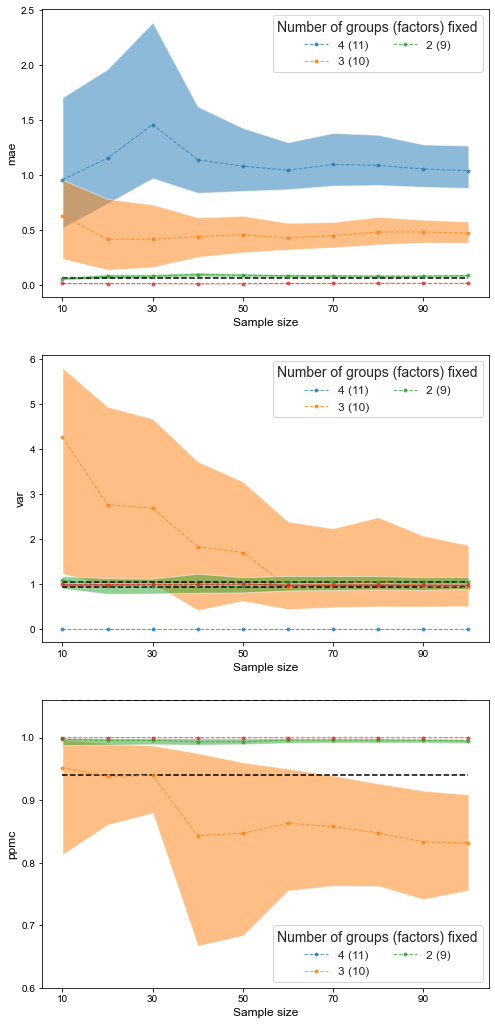

In [6]:
metrics = [fn for fn in METRIC_NAME if not '_' in fn ]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))
fs = 12
lgd = ['4 (11)', '3 (10)', '2 (9)'] # '6 (21)', '5 (17)', '4 (10)', '2 (6)'
sns.set_style('white')
plt.rcParams['legend.title_fontsize'] = 14
for ii in range(len(metrics)):
    metric = metrics[ii]
    ax = df[metric].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax = axes[ii], alpha=0.7)
    cols = df[metric].columns
    for col in cols:
        ax.fill_between(df[metric].index, df[f'{metric}_lower'].loc[:, col], df[f'{metric}_upper'].loc[:, col], alpha = 0.5)
    if ii == 0:
        ax.hlines(0.06, df[metric].index[0], df[metric].index[-1], linestyle = '--')
    else:
        ax.hlines(1.06, df[metric].index[0], df[metric].index[-1], linestyle = '--')
        ax.hlines(0.94, df[metric].index[0], df[metric].index[-1], linestyle = '--')
    ax.set_xlabel('Sample size', fontsize=fs);
    ax.set_ylabel(metric, fontsize = fs);
    if metric == 'ppmc':
        ax.legend(lgd, title='Number of groups (factors) fixed', fontsize = fs, ncol=2, loc='lower right') #bbox_to_anchor = (1, 0.95), 
        ax.set_ylim(0.6, 1.06)
    else:
        ax.legend(lgd, title='Number of groups (factors) fixed', fontsize = fs, ncol=2)
# plt.savefig('../output/figure/metric_adaptive_100.png', format = 'png', dpi = 300)  

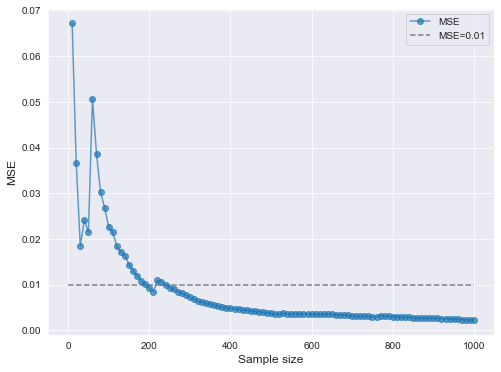

In [7]:
# Plot the MSE of the mean using variance and the sample size
sns.set_style('darkgrid')
ax = mse.plot(legend=False, figsize = (8, 6), marker = 'o', alpha = 0.7)
ax.set_xlabel('Sample size', fontsize=fs)
ax.set_ylabel('MSE', fontsize=fs)
plt.hlines(0.01, xmin=0, xmax=1000, colors='grey', linestyles='--')
ax.legend(['MSE', 'MSE=0.01'])
plt.savefig('../output/figure/mse_mc.png', format = 'png', dpi = 300)

In [16]:
df['mae_upper'].head(20)

,0,1,2,3,4,5,6
10,1.706782,0.957968,0.188023,0.069184,0.040756,0.021551,0.007219
20,1.965415,0.783837,0.160434,0.100104,0.085294,0.017470,0.006577
30,2.389620,0.732475,0.162325,0.098623,0.084277,0.017640,0.005893
40,1.624280,0.615498,0.293176,0.114997,0.069605,0.016104,0.005356
50,1.429609,0.630015,0.258676,0.105382,0.062489,0.016527,0.005627
60,1.299010,0.566192,0.276658,0.098618,0.062546,0.021594,0.006240
70,1.384467,0.573704,0.288725,0.097052,0.060265,0.020677,0.006235
80,1.366400,0.620823,0.270868,0.094329,0.061307,0.021442,0.005980
90,1.279807,0.593996,0.253026,0.094300,0.057001,0.020394,0.006240
100,1.268909,0.577693,0.255747,0.098921,0.059976,0.019324,0.006190
